In [1]:
%matplotlib inline
#This is what %pylab does:
# import numpy
# import matplotlib
# from matplotlib import pylab, mlab, pyplot
# np = numpy
# plt = pyplot
# from IPython.core.pylabtools import figsize, getfigs
# from pylab import *
# from numpy import *
#import matplotlib.pyplot as plt

import os
import sys
import time
import glob
import numpy as np
import cupy as cp
import pandas as pd
from struct import *
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

import skimage
#print(skimage.__version__)
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform, AffineTransform, EuclideanTransform, warp
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
try:
    import skimage.external.tifffile as tiff
except:
    import tifffile as tiff

import dask
import dask.array as da
from dask.distributed import Client, progress, get_task_stream
from dask.diagnostics import ProgressBar

import mrcfile
import pickle
import webbrowser
from IPython.display import IFrame

sys.path.append('/SIFT_gs/')
try:
    from SIFT_gs.FIBSEM_SIFT_gs import *
except:
    from FIBSEM_SIFT_gs import *

Open CV version:  4.6.0


C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depreca

# Set up Local DASK Client and Monitor Window

In [3]:
#start / restart client
try:
    client.restart()
except:
    client = Client()
    
# setup a window to monitor the client progress
try:
    dport = client.scheduler_info()['services']['dashboard']
except:
    dport = client.scheduler_info()['services']['bokeh']
print('Using Local Port:   ', dport)
status_update_address = 'http://localhost:{:d}/status'.format(dport)
IFrame(src=status_update_address, width='100%', height='900px')

Using Local Port:    8787


# Step 0a: Select the Source Directory and Source Files.

In [4]:
fls_dir = 'Y:/Images Jeiss10/Cryo/Y2022/M12'
days = ['D{:02d}'.format(day) for day in np.arange(16, 22)]
days

['D16', 'D17', 'D18', 'D19', 'D20', 'D21']

In [5]:
fls=[]
ftype=0
for day in days:
    fls_dir1 = os.path.join(fls_dir, day)
    if ftype == 0:
        fls1 = sorted(glob.glob(os.path.join(fls_dir1,'*.dat')))
        if len(fls1) < 1:
            fls1 = sorted(glob.glob(os.path.join(fls_dir1,'*/*.dat')))
    if ftype == 1:
        fls1 = sorted(glob.glob(os.path.join(fls_dir1,'*.tif')))
        if len(fls1) < 1:
            fls1 = sorted(glob.glob(os.path.join(fls_dir1,'*/*.tif')))
    fls = fls + fls1

fls = fls[800:]
nfrs = len(fls)
print('Total Number of frames to process: ', nfrs) 

Total Number of frames to process:  10514


# Step 0b: Set up Processing Parameters.

In [6]:
# set the results directory
data_dir = 'Y:/Images Jeiss10/Cryo/Y2022/M12/LID609_ROI2_D16-D19'
#data_dir = 'D:/LID609_ROI2'

ftype = 0 # 0 for Shan's .dat files, 1 for tif files

use_DASK = True
DASK_client_retries = 3  # Number of allowed automatic retries if a task fails


threshold_min = 1e-3    # These are used to determine Min and Max data boundaries for I8 conversion
threshold_max = 1e-3                            
sliding_minmax = True   # If True, Global Min and Max for I8 conversion the entire data set is used. If False, Min and Max are allowed to vary slowly.
nbins = 256             # Number of histogram bins for determining Min and Max above

BFMatcher = False       # If True, the BF Matcher is used for keypont matching
                        # otherwise FLANN Matcher (faster, preferable) is used.

save_matches = True     # If True, matches will be saved into individual files

kp_max_num = 100000      # max number of key-points to be matched. Key-points in every frame are indexed (in descending order)
                        # by the strength of the response. Only kp_max_num is kept for further processing.
                        # Set this value to -1 if you want to keep ALL keypoints (may take forever to process!)

# Uncomment one from the below choices:
#TransformType = ShiftTransform                #  only x-shift and y-shift
#TransformType = XScaleShiftTransform          #  x-scale, x-shift, y-shift
#TransformType = ScaleShiftTransform           #  x-scale, y-scale, x-shift, y-shift
#TransformType = AffineTransform               #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
TransformType = RegularizedAffineTransform     #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
                                                # with regularization on deviation from ShiftTransform
if TransformType == RegularizedAffineTransform:
    l2_param = 1e-5                                  # regularization strength (shrinkage parameter)
    l2_matrix = np.eye(6)*l2_param                   # initially set equal shrinkage on all coefficients
    l2_matrix[2,2]=0                                 # turn OFF the regularization on shifts
    l2_matrix[5,5]=0                                 # turn OFF the regularization on shifts
    targ_vector = np.array([1, 0, 0, 0, 1, 0])       # target transformation is shift only: Sxx=Syy=1, Sxy=Syx=0
    suffix = 'l2_{:.0e}'.format(l2_matrix[0,0])
else:
    l2_matrix= None
    targ_vector = None
    suffix = 'bilin'                  # optonal characters that will be added to the end of the filename (before the extension)

SIFT_nfeatures = 0     # SIFT libary default is 0. The number of best features to retain.
                                # The features are ranked by their scores (measured in SIFT algorithm as the local contrast)
    
SIFT_nOctaveLayers = 3          # SIFT libary default  is 3. The number of layers in each octave.
                                # 3 is the value used in D. Lowe paper. The number of octaves is computed automatically from the image resolution.

SIFT_contrastThreshold = 0.025   # SIFT libary default  is 0.04. The contrast threshold used to filter out weak features in semi-uniform (low-contrast) regions.
                                # The larger the threshold, the less features are produced by the detector.
                                # The contrast threshold will be divided by nOctaveLayers when the filtering is applied.
                                # When nOctaveLayers is set to default and if you want to use the value used in
                                # D. Lowe paper (0.03), set this argument to 0.09.
                                
SIFT_edgeThreshold = 10         # SIFT libary default  is 10. The threshold used to filter out edge-like features.
                                # Note that the its meaning is different from the contrastThreshold,
                                # i.e. the larger the edgeThreshold, the less features are filtered out
                                # (more features are retained).

SIFT_sigma = 1.6                # SIFT library default is 1.6. 	The sigma of the Gaussian applied to the input image at the octave #0.
                                # If your image is captured with a weak camera with soft lenses, you might want to reduce the number.
    
Lowe_Ratio_Threshold = 0.7

solver = 'RANSAC'       # String indicating which solver is to be used.'RANSAC' will use RANSAC (Random Sample Consensus) algorithm.
                        # 'LinReg' will use Linear Regression with iterative "Throwing out the Worst Residual" Heuristic

drmax = 1.5              # dimensions - pixels.
                         #  - in the case of 'RANSAC' - Maximum distance for a data point to be classified as an inlier.
                         #  - in the case of 'LinReg' - outlier threshold for iterative regression:
                         # For each matched pair of keypoins the error is calculated as err[j] = dst_pts[j] - A*src_pts[j]
                         # The iterative procedure throws away the matched keypoint pair with worst error on every iteration
                         # until the worst error falls below drmax or the max number of iterations is reached.

max_iter = 1000     # max number of iterations in the iterative procedure above

save_data_as_tiff = False    # Convert and Save the InLens.tif data

save_res_png = True        # Save PNG images of the intemediate processing statistics and final registration quality check.

save_asI8 = False            # If true, the data will be converted to I8 using global MIN and MAX values determined in the Step 1

preserve_scales = True       # If True, the transformation matrix will be adjusted using the settings defined by fit_params below
fit_params = ['SG', 101, 3]  # perform the above adjustment using  Savitzky-Golay (SG) filter with parameters
                             # window size 501, polynomial order 3
#fit_params = ['LF']         # another option is to use linear fit with forces start points Sxx and Syy = 1 and Sxy and Syx = 0
#fit_params = ['PF', 2]      # another option is to use polynomial fit (in this case of order 2)

subtract_linear_fit = [True, True]  # If True, the linear slopes along X- and Y- directions (respectively) will be subtracted from the cumulative shifts.
                                    # This is performed after the optimal frame-to-frame shifts are recalculated for preserve_scales = True 
subtract_FOVtrend_from_fit = [True, True]  # If True, FOV trends (image shifts performed during imaging) will be subtracted first, so they do not bias the linear trends.

pad_edges = True             # If True, the edges will be padded with the amount equal to max shift excursion in each direction

flipY = False                 # If True, the dataset will be flipped along Y-direction

zbin_factor =  2             # binning factor in z-direction (milling direction). Data will be binned when saving the final result. Default is 1.

int_order = 1                #     The order of interpolation. The order has to be in the range 0-5:
                             #    - 0: Nearest-neighbor
                             #    - 1: Bi-linear (default)
                             #    - 2: Bi-quadratic
                             #    - 3: Bi-cubic
                             #    - 4: Bi-quartic
                             #    - 5: Bi-quintic
#suffix = suffix + '_r1'
#********************************************************************************************************
# DO NOT MODIFY THE CODE BELOW!
#********************************************************************************************************           

if fit_params[1] > nfrs//2*2-1:  # if smoothing aperture (Sov-Gol) is larger than number of frames, reduce the aperture
    fit_params[1] = nfrs//2*2-1

fnm0 = (os.path.join(data_dir,fls[0]))
frame0 = FIBSEM_frame(fnm0, ftype=ftype)
Sample_ID = frame0.Sample_ID.strip('\x00')
EightBit = frame0.EightBit

SIFT_kwargs = {
    'ftype' : ftype,
    'data_dir' : data_dir,
    'Sample_ID' : Sample_ID,
    'EightBit' : EightBit,
    'use_DASK' : use_DASK,
    'DASK_client_retries' : DASK_client_retries,
    'threshold_min' : threshold_min, 
    'threshold_max' : threshold_max,
    'sliding_minmax' : sliding_minmax,
    'nbins' : nbins,
    'TransformType' : TransformType,
    'SIFT_nfeatures' : SIFT_nfeatures,
    'SIFT_nOctaveLayers' : SIFT_nOctaveLayers,
    'SIFT_contrastThreshold' : SIFT_contrastThreshold,
    'SIFT_edgeThreshold' : SIFT_edgeThreshold,
    'SIFT_sigma' : SIFT_sigma,
    'Lowe_Ratio_Threshold' : Lowe_Ratio_Threshold,
    'l2_matrix' : l2_matrix,
    'targ_vector': targ_vector, 
    'solver' : solver,
    'drmax' : drmax,
    'max_iter' : max_iter,
    'BFMatcher' : BFMatcher,
    'save_matches' : save_matches,
    'kp_max_num' : kp_max_num,
    'save_res_png' : save_res_png,
    'save_data_as_tiff' : save_data_as_tiff,
    'save_asI8' : save_asI8,
    'preserve_scales' : preserve_scales,
    'fit_params' : fit_params,
    'subtract_linear_fit' : subtract_linear_fit,
    'subtract_FOVtrend_from_fit' : subtract_FOVtrend_from_fit,
    'pad_edges' : pad_edges,
    'flipY' : flipY,
    'zbin_factor' : zbin_factor,
    'int_order' : int_order,
    'suffix' : suffix}

test_dataset = FIBSEM_dataset(fls, fnm_reg = 'Registered_LID609_ROI2_brat0.00.mrc', **SIFT_kwargs)

Total Number of frames:  10514
Registered data will be saved into:  Registered_LID609_ROI2_brat0.00.mrc


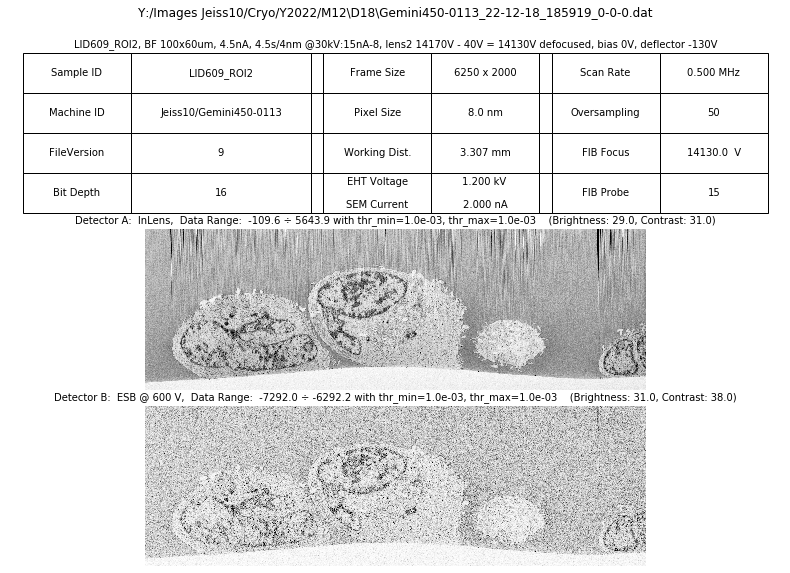

In [7]:
test_frame = FIBSEM_frame(fls[len(fls)//2])
test_frame.save_snapshot()

# Check the settings: Perform SIFT alignements on two frames in the middle of the stack

LID609_ROI2
Transformation Matrix determined using RegularizedAffineTransform using RANSAC solver
[[ 1.00009577e+00 -1.20052682e-04 -1.41046532e-01]
 [-1.09725470e-05  9.99959772e-01 -8.90192259e-02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
12912 keypoint matches were detected with 1.5 pixel outlier threshold
Number of iterations: 397
Wall time: 44.2 s


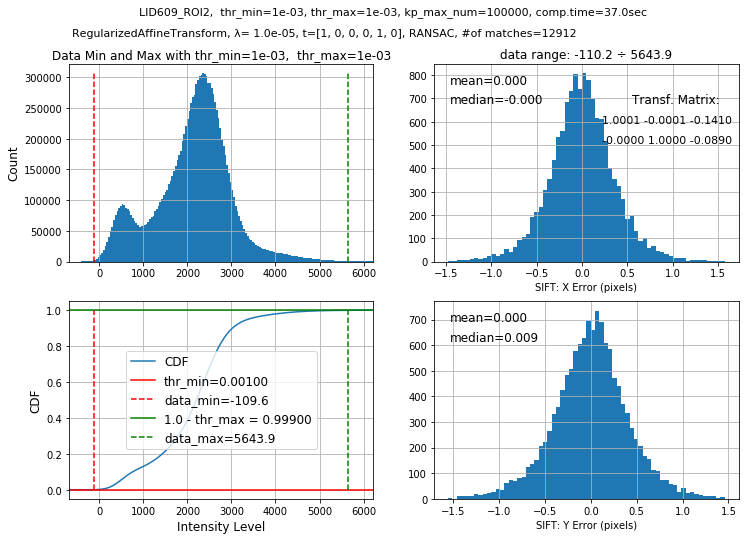

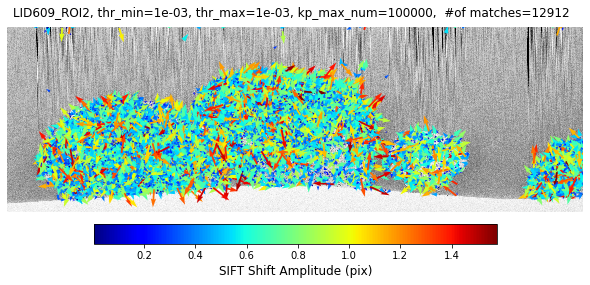

In [8]:
%%time
SIFT_evaluation_results = test_dataset.SIFT_evaluation()

# Step 1a. Evaluate Field Flatness and determine Correction Parameters

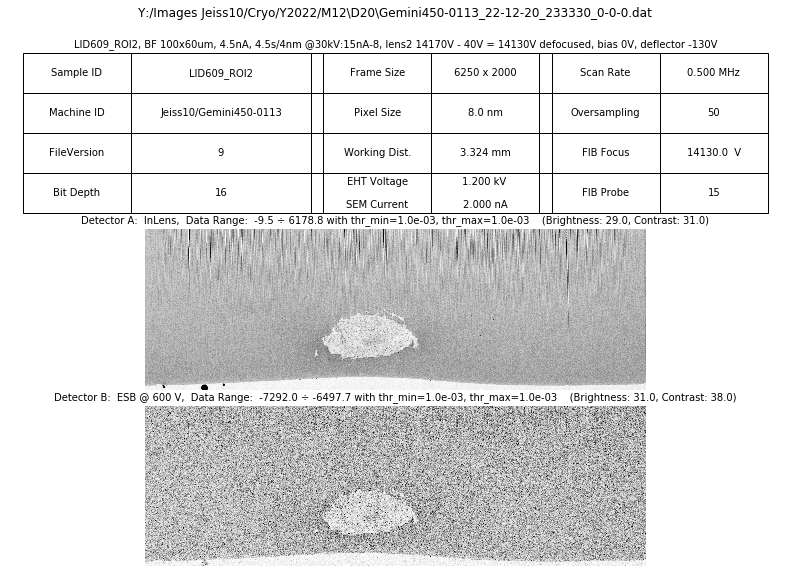

In [9]:
test_frame_ind = 9330
test_frame_ind = 10000
test_frame = FIBSEM_frame(fls[test_frame_ind])
test_frame.save_snapshot()

Estimator coefficients ( 1  x  y  x^2  x*y  y^2):  [ 0.00000000e+00 -2.07333997e-01 -2.87640566e+00  4.61877312e-04
  7.40888612e-04  2.60496645e-02]
Estimator intercept:  9248.10437986489
Estimator coefficients ( 1  x  y  x^2  x*y  y^2):  [ 0.00000000e+00  5.12471798e-02 -9.26934737e-01  3.11279963e-05
 -3.38554094e-04  4.33489345e-03]
Estimator intercept:  541.9487709610632
Image Flattening Info saved into the binary file:  Y:/Images Jeiss10/Cryo/Y2022/M12/LID609_ROI2_D16-D19\Gemini450-0113_22-12-20_233330_0-0-0_flatfield_corr.bin


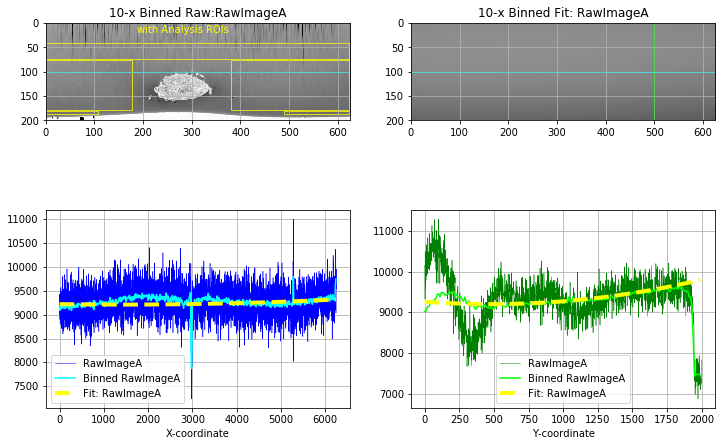

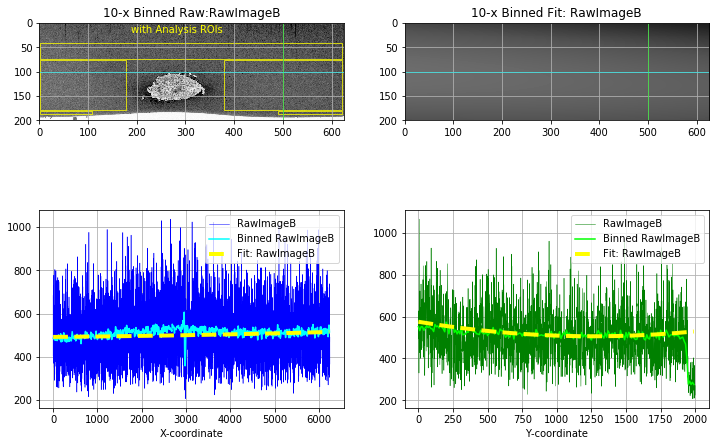

In [10]:
'''
Analysis_ROIs=[[10, 6240, 400, 750],
               [10, 1800, 751, 1800],
               [10, 1100, 1801, 1890],
               [3800, 6240, 751, 1800],
              [4900, 6240, 1801, 1890]]
'''
Analysis_ROIs=[[10, 6240, 400, 750],
               [10, 1800, 751, 1800],
               [10, 1100, 1801, 1890],
               [3800, 6240, 751, 1800],
              [4900, 6240, 1801, 1890]]
corr_fname_png = os.path.splitext(os.path.split(fls[test_frame_ind])[1])[0] + '_flatfield_corr.png'
res_fname = os.path.join(data_dir, corr_fname_png)
flattening_params = test_frame.determine_field_fattening_parameters(image_names = ['RawImageA', 'RawImageB'],
                                                                     estimator = RANSACRegressor(),
                                                                     bins=10, Analysis_ROIs=Analysis_ROIs, Xsect=5000,
                                                                     calc_corr=True, save_correction_binary=True,
                                                                   res_fname = res_fname)
# assign the image_correction_file to the object test_dataset
test_dataset.image_correction_file = test_frame.image_correction_file

# Step 1b. Test Image Correction (Flattening)

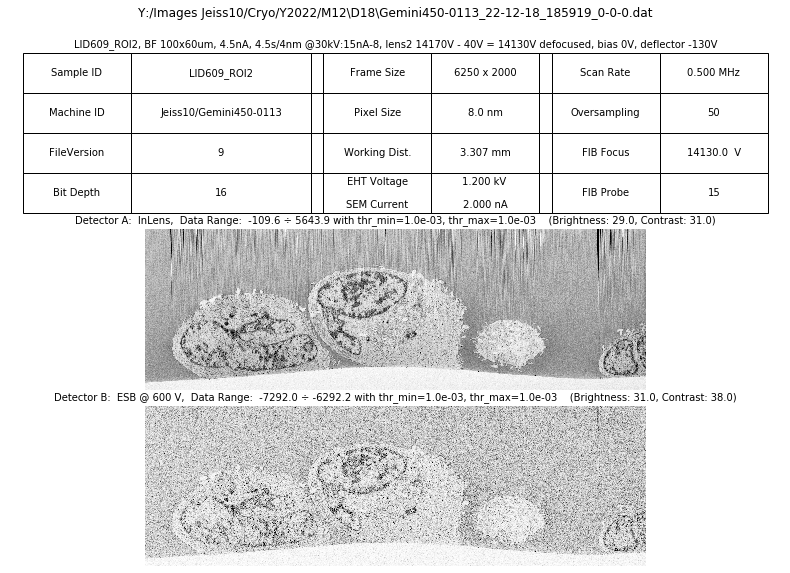

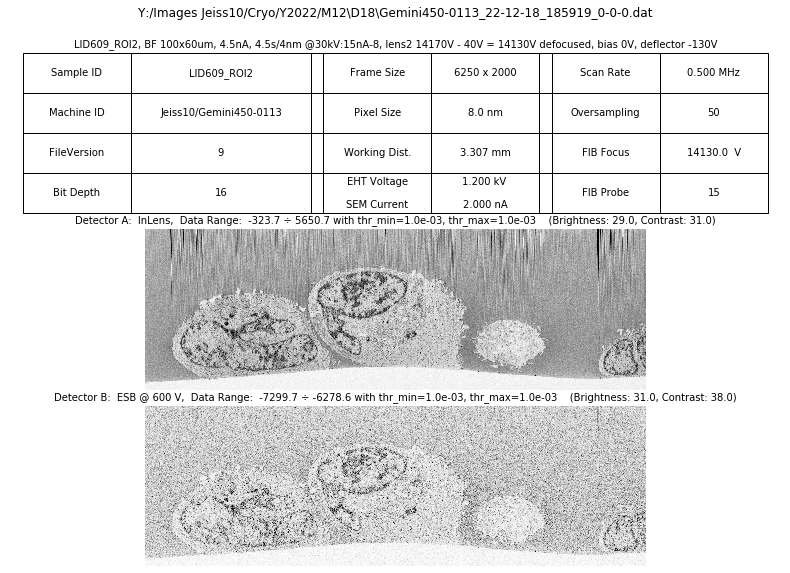

In [11]:
# test image correction
mid_frame = FIBSEM_frame(fls[len(fls)//2])
mid_frame.save_snapshot(snapshot_name = mid_frame.fname.replace('.dat', '_original_snapshot.png'))
mid_frame.RawImageA, mid_frame.RawImageB = mid_frame.flatten_image(image_correction_file = test_frame.image_correction_file)
mid_frame.save_snapshot(snapshot_name = mid_frame.fname.replace('.dat', '_flattened_snapshot.png'))

In [12]:
# if all is good - assign the image correction file to the test_dataset object
test_dataset.image_correction_file = test_frame.image_correction_file

# This is where the data processing begins. Perform SIFT Computations using DASK Distributed (local cluster, using SCATTER, MAP and GATHER)

# Step 2: Save InLens.tif Data (Optional)

In [13]:
if save_data_as_tiff:
    test_dataset.convert_raw_data_to_tif_files(client)

# Step 2b: Estimate Pixel Size in Z - Direction and Get FOV center shifts

Step 2b: Calculate Z Pixel Size
Loading kwarg info
Loading Working Distance and Milling Y Voltage Data
Generating Plot
Step 2b: Elapsed time: 1120.06 seconds
Z pixel (after 2-x Z-binning) = 7.43 nm - based on WD data
Z pixel (after 2-x Z-binning) = 6.37 nm - based on Milling Voltage data


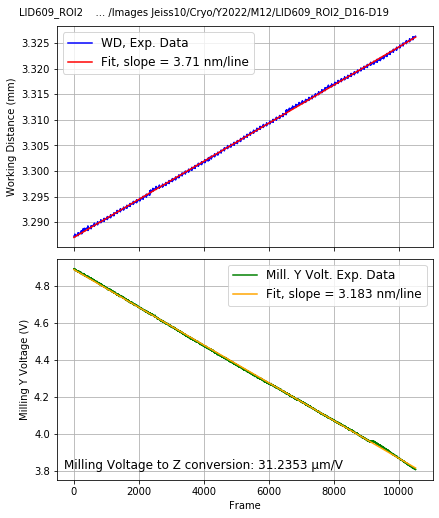

In [14]:
# Step 2b: Estimate Pixel Size in Z - Direction from Working Distance and Milling Y Voltage data

t0 = time.time()
print('Step 2b: Calculate Z Pixel Size')
milling_data =  test_dataset.estimate_Z_pixel_size(client)
generate_report_mill_rate_xlsx(milling_data[0])

t1 = time.time()
print('Step 2b: Elapsed time: {:.2f} seconds'.format(t1 - t0))
if test_dataset.zbin_factor > 1:
    print('Z pixel (after {:d}-x Z-binning) = {:.2f} nm - based on WD data'.format(test_dataset.zbin_factor, milling_data[1]))
    print('Z pixel (after {:d}-x Z-binning) = {:.2f} nm - based on Milling Voltage data'.format(test_dataset.zbin_factor, milling_data[2]))
else:
    print('Z pixel = {:.2f} nm  - based on WD data'.format(milling_data[1]))
    print('Z pixel = {:.2f} nm  - based on Milling Voltage data'.format(milling_data[2]))

In [15]:
# set voxel_size property
voxel_size = np.rec.array((test_dataset.PixelSize,  test_dataset.PixelSize,  milling_data[1]), dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4')])
test_dataset.voxel_size = voxel_size

# Display FOV Center shifts.

Loading kwarg info
Loading FOV Center Location Data
Generating Plot


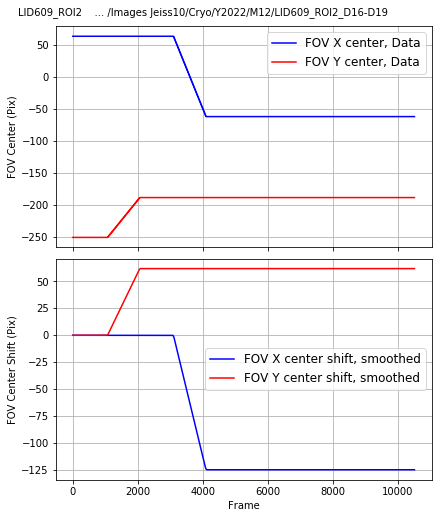

In [16]:
FOVtrend_x, FOVtrend_y = generate_report_FOV_center_shift_xlsx(milling_data[0])
#test_dataset.FOVtrend_x = FOVtrend_x
#test_dataset.FOVtrend_y = FOVtrend_y

# Step 2c: Calculate the Global Data Range

Step 2c: Calculate the Global Data Range
Using DASK distributed
Saving the Data Min/Max Statistics into the file:  Y:/Images Jeiss10/Cryo/Y2022/M12/LID609_ROI2_D16-D19\Data_MinMax.xlsx
Loading SIFT kwarg Data
Loading MinMax Data
Generating Plot
Step 2c: Elapsed time: 1356.53 seconds
Global Data Range for I8 conversion:  Min=-681.12, Max=7456.41


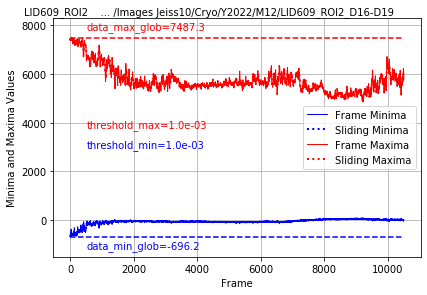

In [17]:
# Step 2c: Calculate the Global Data Range

t0 = time.time()
print('Step 2c: Calculate the Global Data Range')
data_minmax =  test_dataset.calc_data_range(client)
generate_report_data_minmax_xlsx(data_minmax[0])

t1 = time.time()
print('Step 2c: Elapsed time: {:.2f} seconds'.format(t1 - t0))
print('Global Data Range for I8 conversion:  Min={:.2f}, Max={:.2f}'.format(data_minmax[1], data_minmax[2]))

# Steps 3 and 4: Extract Key Points and Descriptors, Find Matches and Transformations

Calculating Cummilative Transformation Matrix:   0%|          | 0/10513 [00:00<?, ?it/s]

Recalculating the shifts for preserved scales:   0%|          | 0/10513 [00:00<?, ?it/s]

Loading SIFT kwarg Data
Loading Original Transformation Data
Loading Cumulative Transformation Data
Loading Intermediate Data
Loading Statistics


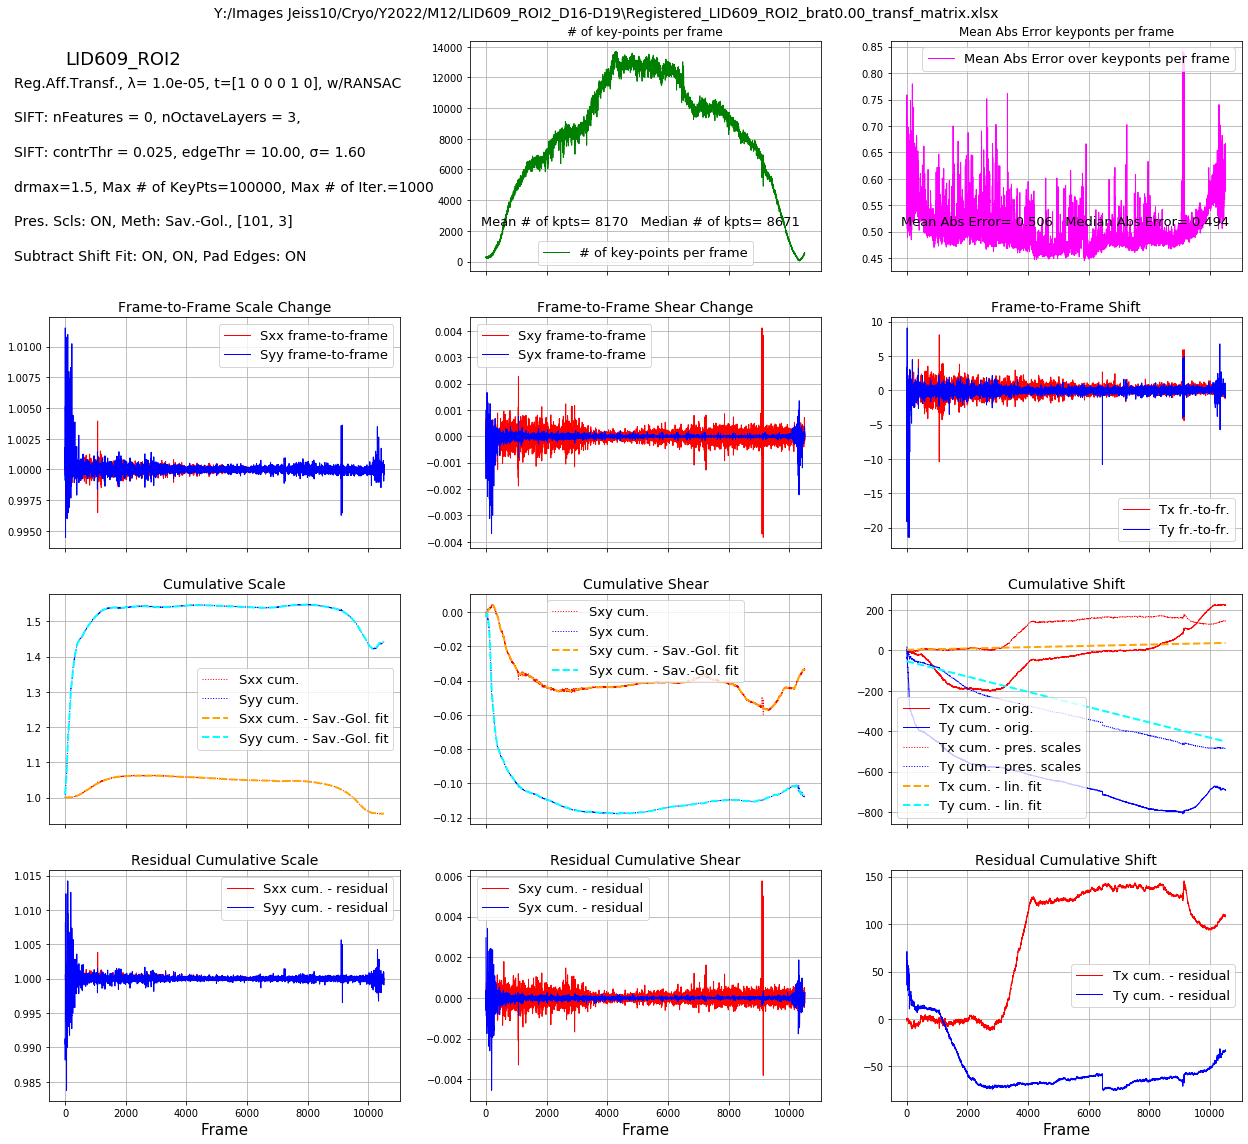

In [21]:
%%time
# Step 3: Extract Key Points and Descriptors using DASK Distributed
t1 = time.time()
print('Step 3: Extract Key Points and Descriptors')
fnms = test_dataset.extract_keypoints(client)   
t2 = time.time()
print('Step 3: Elapsed time: {:.2f} seconds'.format(t2 - t1))
print('')

# Step 4: Select good matches and extract transformation parameters using DASK Distributed
matcher_str = 'BF' if BFMatcher else 'FLANN'
print('Step 4: Select Good Matches with ' + matcher_str + ' matcher')
print('Step 4: using ' + test_dataset.TransformType.__name__ + ' Transformation Model with ' + solver + ' solver')
if TransformType == RegularizedAffineTransform:
    print('Step 4: ' + test_dataset.TransformType.__name__ + ' parameters:')
    print('Step 4: Regularization matrix: ')
    print(test_dataset.l2_matrix)
    print('Step 4: Target Solution: ', test_dataset.targ_vector)

results_s4 = test_dataset.determine_transformations(client)
t3 = time.time()
print('Step 4: Elapsed time: {:.2f} seconds'.format(t3 - t2))

tr_matr_cum_residual, tr_matr_cum_xlsx_file = test_dataset.process_transformation_matrix()
generate_report_transf_matrix_from_xlsx(tr_matr_cum_xlsx_file)

In [22]:
# here is an example of how the previous step can be modified easily without having to re-do all previous steps
# this will calculate the cumulative transformation matrix WITHOT modifying the object property subtract_linear_fit
# so this change will NOT propagate.
# tr_matr_cum_residual = test_dataset.process_transformation_matrix(subtract_linear_fit = [False, True])

# if you want to make permanet change, then you should do this:
# test_dataset.subtract_linear_fit = [False, True]
# tr_matr_cum_residual = test_dataset.process_transformation_matrix()


# Step 5: Search for frames with no (or low # of) matches and possibly remove them.

In [23]:
thr_npt = 3   # consider frame with less than 3 Key Points for removal
tr_matr_cum_residual = test_dataset.check_for_nomatch_frames(thr_npt, **SIFT_kwargs)

Frames with no matches to the next frame:   []
Frames to remove:   []
No frames selected for removal


# Step 6: Recall or Save the Intermediate Data (KeyPoints, Matches, Transf.Matrix, etc.) from / into spreadsheets and a binary files.  Remove the intermediate KeyPoint/Descriptor files.

In [24]:
recall_the_data = False          # if False, the data will be saved. if True, the data will be recalled

dump_filename = os.path.join(data_dir, test_dataset.fnm_reg.replace('.mrc', '_params.bin'))

if recall_the_data:
    test_dataset = FIBSEM_dataset(fls, recall_parameters=True, dump_filename=dump_filename, **SIFT_kwargs)
else:
    saved_dump_file = test_dataset.save_parameters(dump_file=dump_filename)
    print('Parameters saved into the file: ', saved_dump_file)

Parameters saved into the file:  Y:/Images Jeiss10/Cryo/Y2022/M12/LID609_ROI2_D16-D19\Registered_LID609_ROI2_brat0.00_params.bin


In [25]:
remove_key_points_data = False   # if True, the binary files with intermediate keypoints data for each frame will be removed

# Remove temporary files
if remove_key_points_data:
    # Remove the keypoint/ descriptor files
    for fnm in tqdm(fnms, desc='Removing KeyPoint/Descriptor Files: '):
        try:
            os.remove(os.path.join(data_dir, fnm))
        except:
            pass
    for fnm in tqdm(fnms_matches, desc='Removing Matched KeyPoint Files: '):
        try:
            os.remove(os.path.join(data_dir, fnm))
        except:
            pass

# Define Evaluation Box

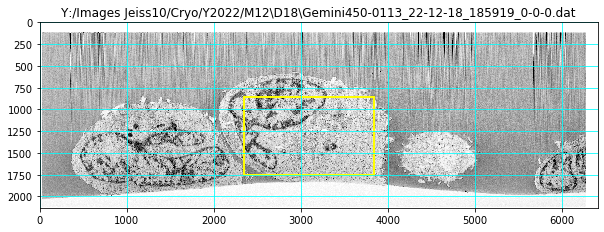

In [26]:
#evaluation_box = [250, 2000, 1450, 2650]      # optional evaluation box for defining the area over which the registration quality
#test_dataset.show_eval_box(evaluation_box = evaluation_box, invert_data=False)
#
# default frames are three frames: 10% from the start, 50% from the start, and 90% from the start
# alternatively you can set any list of frame indecis by using keyword frame_indices
# for example:0
# test_dataset.show_eval_box(frame_indices=[1, 100, 850], evaluation_box = evaluation_box, invert_data=False)
#
evaluation_box = [800, 900, 2200, 1500] 
test_dataset.show_eval_box(invert_data=False, frame_inds=[len(fls)//2], evaluation_box=evaluation_box)

# Evaluate Image B fraction for fused image using Auto-Correlation and Cross-Correlation

Analyzing Auto-Correlation SNRs :   0%|          | 0/1 [00:00<?, ?it/s]

Saved the results into the file:  Y:/Images Jeiss10/Cryo/Y2022/M12/LID609_ROI2_D16-D19\Gemini450-0113_22-12-18_185919_0-0-0_ImgA_SNR.png
Saved the results into the file:  Y:/Images Jeiss10/Cryo/Y2022/M12/LID609_ROI2_D16-D19\Gemini450-0113_22-12-18_185919_0-0-0_ImgB_SNR.png


Re-analyzing Auto-Correlation SNRs for fused image:   0%|          | 0/1 [00:00<?, ?it/s]

Saved the results into the file:  Y:/Images Jeiss10/Cryo/Y2022/M12/LID609_ROI2_D16-D19\Gemini450-0113_22-12-18_185919_0-0-0_ImgB_fr0.060_SNR.png


(0.01589606130658751, 0.04723177473664148, 0.060105422487272575)

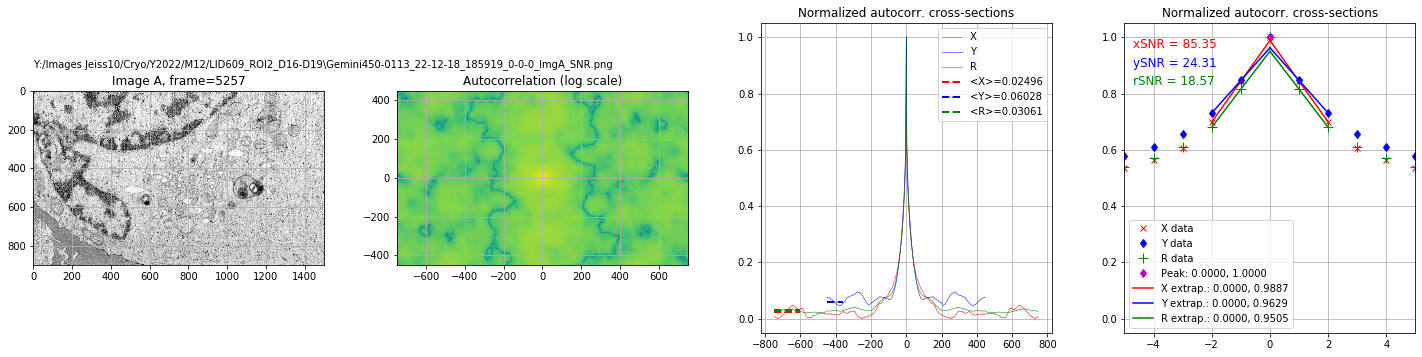

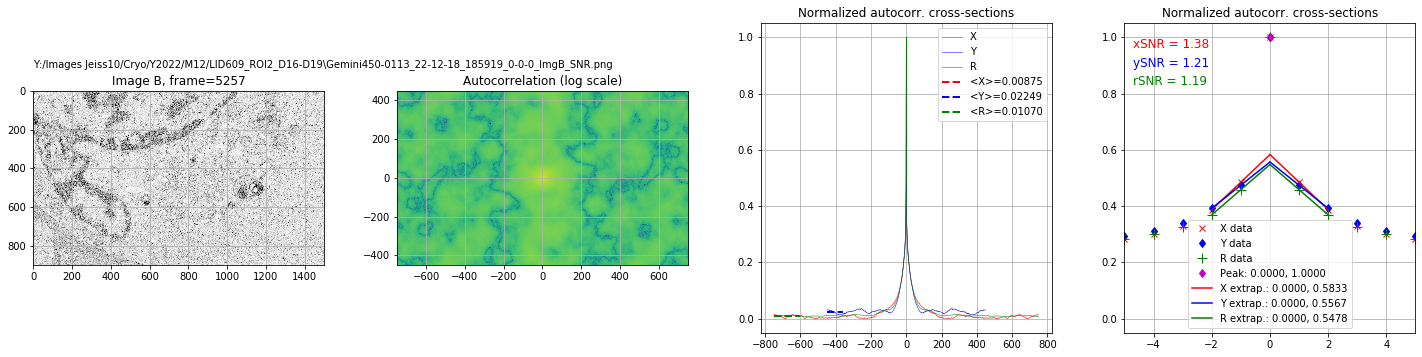

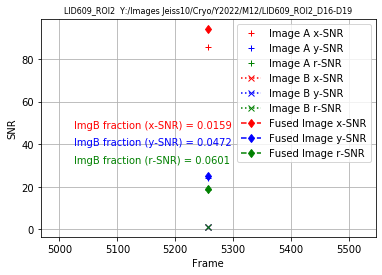

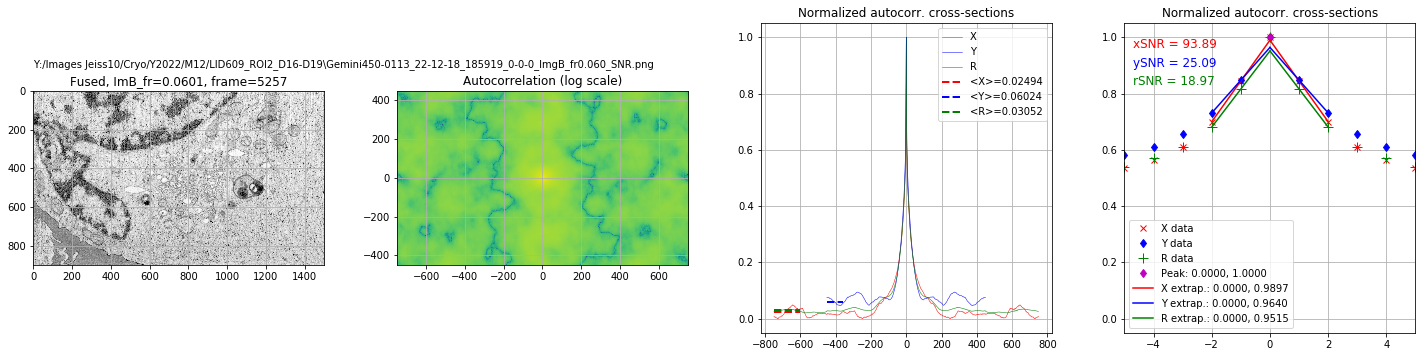

In [27]:
test_dataset.estimate_SNRs(frame_inds=[len(fls)//2], evaluation_box = evaluation_box, save_res_png=True)

Evaluating Img B fractions:   0%|          | 0/21 [00:00<?, ?it/s]

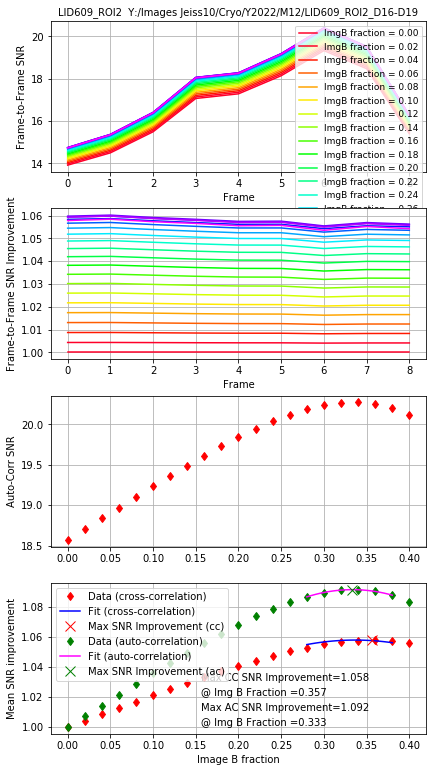

In [28]:
frame_inds = np.arange(10) + len(test_dataset.fls)//2
ImgB_fractions = np.linspace(0.00, 0.40, 21)
ImgB_fr_optimal_mid = test_dataset.evaluate_ImgB_fractions(ImgB_fractions, frame_inds, evaluation_box = evaluation_box)

Analyzing Auto-Correlation SNRs :   0%|          | 0/1 [00:00<?, ?it/s]

Saved the results into the file:  Y:/Images Jeiss10/Cryo/Y2022/M12/LID609_ROI2_D16-D19\Gemini450-0113_22-12-18_185919_0-0-0_ImgA_SNR.png
Saved the results into the file:  Y:/Images Jeiss10/Cryo/Y2022/M12/LID609_ROI2_D16-D19\Gemini450-0113_22-12-18_185919_0-0-0_ImgB_SNR.png


Re-analyzing Auto-Correlation SNRs for fused image:   0%|          | 0/1 [00:00<?, ?it/s]

Saved the results into the file:  Y:/Images Jeiss10/Cryo/Y2022/M12/LID609_ROI2_D16-D19\Gemini450-0113_22-12-18_185919_0-0-0_ImgB_fr0.100_SNR.png


(0.01589606130658751, 0.04723177473664148, 0.060105422487272575)

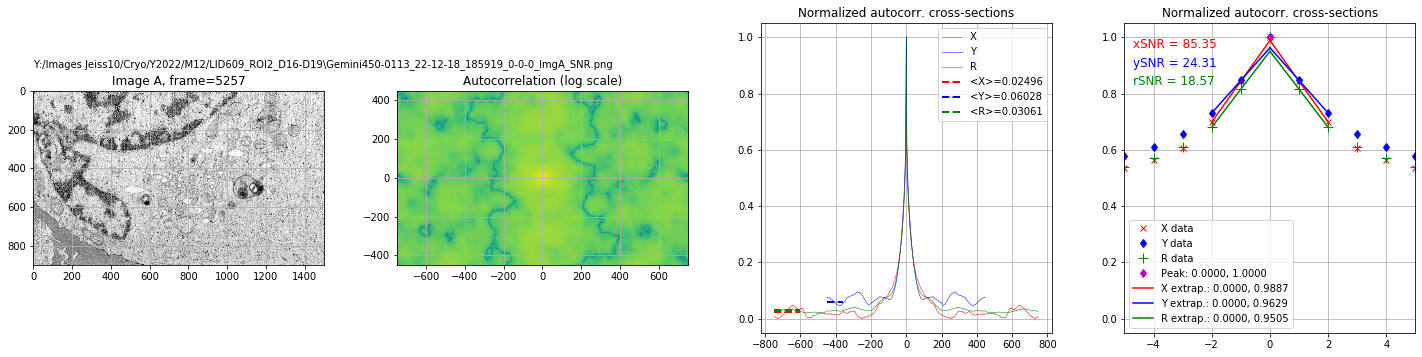

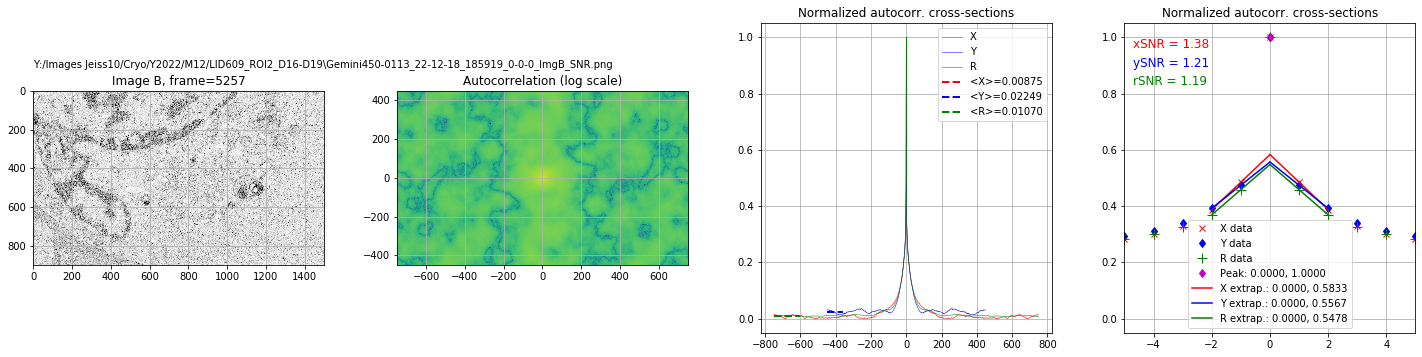

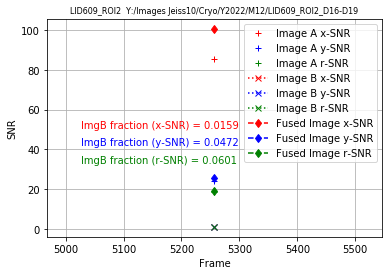

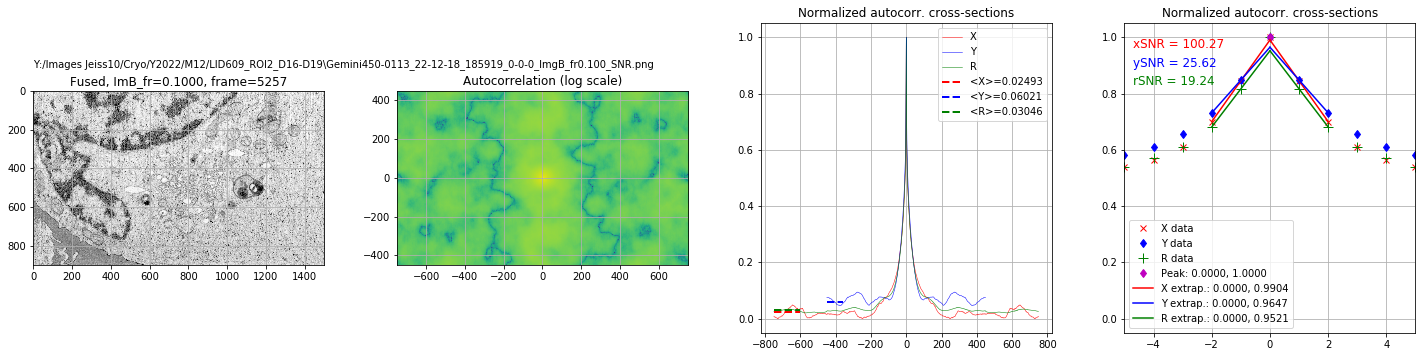

In [29]:
test_dataset.estimate_SNRs(frame_inds=[len(fls)//2], ImgB_fraction = 0.10, evaluation_box = evaluation_box, save_res_png=True)

# Step 7: Transform and Save the FIB-SEM data

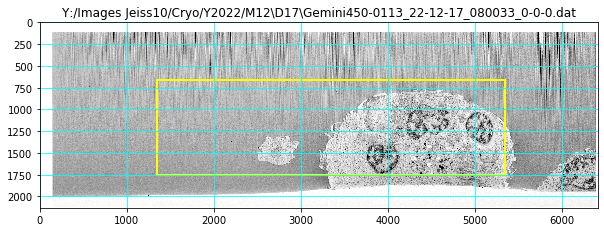

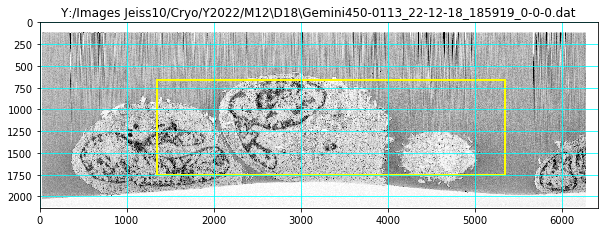

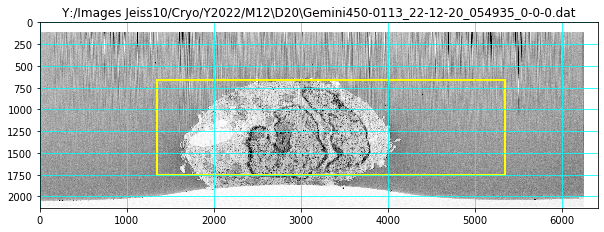

In [30]:
evaluation_box = [600, 1100, 1200, 4000]
test_dataset.show_eval_box(invert_data=False,
                           frame_inds = [nfrs//5, nfrs//2, nfrs//5*4],
                           evaluation_box=evaluation_box)

Step 7: Transform and Save the FIB-SEM data


Determining the pad offsets:   0%|          | 0/10514 [00:00<?, ?it/s]

Saving the registered and 2-x z-binned stack into the file:  Y:/Images Jeiss10/Cryo/Y2022/M12/LID609_ROI2_D16-D19\LID609_ROI2_RegAffine_l2_1e-05_brat0.10_flattened.mrc
The resulting stack shape will be  nx=6413, ny=2131, nz=5257,  data type: <class 'numpy.int16'>
Will perform local computations


Saving into I16 MRC File:   0%|          | 0/5257 [00:00<?, ?it/s]

Saving the Registration Quality Statistics into the file:  Y:/Images Jeiss10/Cryo/Y2022/M12/LID609_ROI2_D16-D19\LID609_ROI2_RegAffine_l2_1e-05_brat0.10_flattened_RegistrationQuality.xlsx
Wall time: 11h 46min 17s


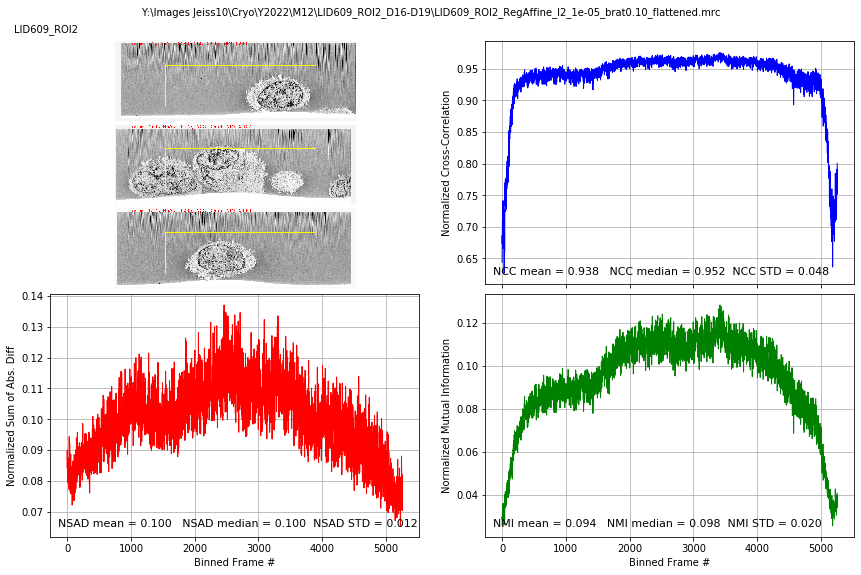

In [31]:
%%time

print('Step 7: Transform and Save the FIB-SEM data')

test_dataset.fnm_reg = 'LID609_ROI2_RegAffine_l2_1e-05_brat0.10_flattened.mrc'

evaluation_box = [600, 1100, 1200, 4000] 

reg_summary_RegAffine_ImB0p10_flattened, reg_summary_RegAffine_ImB0p10_flattened_xlsx = test_dataset.transform_and_save(client,
                                                        use_DASK=True,
                                                        save_transformed_dataset = True,
                                                        save_registration_summary = True,
                                                        flatten_image = True,
                                                        ImgB_fraction=0.10,
                                                        zbin_factor = 2,
                                                        evaluation_box = evaluation_box,
                                                        sliding_evaluation_box = False)

generate_report_from_xls_registration_summary(reg_summary_RegAffine_ImB0p10_flattened_xlsx)

# Crop / Z-bin MRC stack

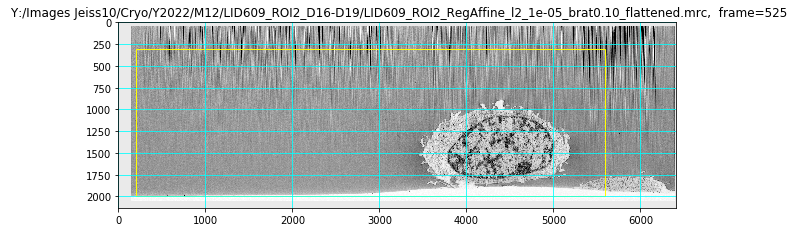

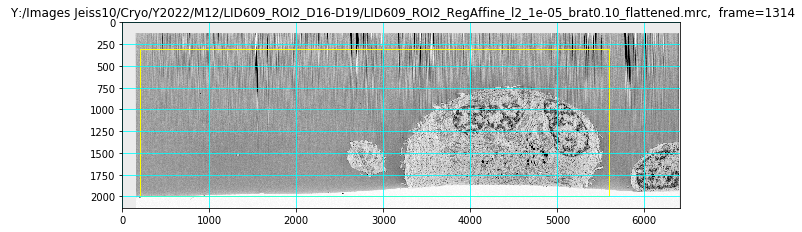

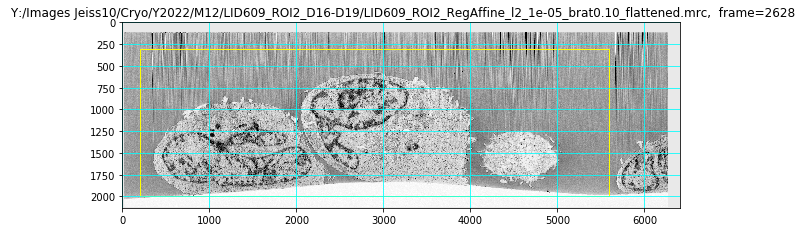

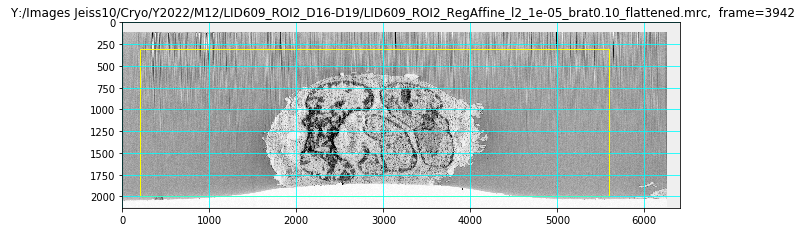

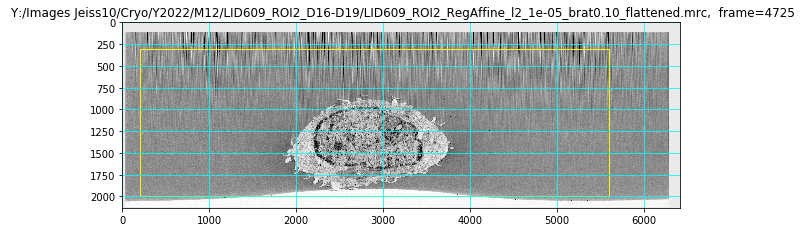

In [32]:
orig_mrc = 'Y:/Images Jeiss10/Cryo/Y2022/M12/LID609_ROI2_D16-D19/LID609_ROI2_RegAffine_l2_1e-05_brat0.10_flattened.mrc'
evaluation_box = [300, 1700, 200, 5400] 
show_eval_box_mrc_stack(orig_mrc, evaluation_box=evaluation_box, frame_inds = [nfrs//20,  nfrs//8, nfrs//4, nfrs//8*3, nfrs//20*9])

In [33]:
cropped_mrc = 'Y:/Images Jeiss10/Cryo/Y2022/M12/LID609_ROI2_D16-D19/LID609_ROI2_RegAffine_l2_1e-05_brat0.10_flattened_cropped.mrc'
zbin_crop_mrc_stack(orig_mrc, 1, binned_mrc_filename=cropped_mrc, xi=200, xa=5600, yi=400, ya=2000)

Source mrc_mode: 1, source data type: <class 'numpy.int16'>
Result mrc_mode: 1, source data type: <class 'numpy.int16'>
New Data Set Shape:  5400 x 1600 x 5257


Binning MRC stack:   0%|          | 0/5257 [00:00<?, ?it/s]

C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
